In [32]:
import pydpmd as dp
from pydpmd.utils import split_systems, join_systems
from pydpmd.plot import draw_particles_frame
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib.colors import LogNorm
from tqdm import tqdm

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.max())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])


In [216]:
def get_data(dirname):
    dataset = {
        'nv': [],
        'mu': [],
        'phi': [],
        'g_small': [],
        'g_large': [],
        'r': []
    }
    for dirpath, dirnames, filenames in tqdm(os.walk(dirname)):
        if 'meta.h5' in filenames and 'dynamics_' in os.path.basename(dirpath):
            for data in split_systems(dp.data.load(dirpath, location=['final', 'init'])):
                data.calculate_mu_eff()
                dataset['nv'].append(data.n_vertices_per_particle[0])
                dataset['mu'].append(data.mu_eff[0])
                dataset['phi'].append(data.packing_fraction[0])
                dataset['g_small'].append(data.final.g[:, 0].squeeze())
                dataset['g_large'].append(data.final.g[:, 1].squeeze())
                dataset['r'].append(data.final.r)
    return pd.DataFrame(dataset, dtype=object)

def get_containining_consecutive_segment(full_span, value_to_contain, jump_threshold):
    """
    Find the segment in the full_span array that is consecutive under jump_threshold jumps that contains value_to_contain
    """
    i_prev = 0
    split_ids = np.argwhere(np.diff(full_span) > jump_threshold).flatten()
    if len(split_ids) == 0:
        return full_span
    for i_next in split_ids:
        if value_to_contain in full_span[i_prev:i_next]:
            return full_span[i_prev:i_next]
    raise ValueError('Could not find spanning segment that contains desired value!')

def get_peak_stats(g, r, dr_jump_multiple=5):
    r0 = r[np.argmax(g)]
    g0 = np.max(g)
    r_range_first_peak_half_max = r[g > g0 / 2]

    dr = r[1] - r[0]
    r_range_first_peak_half_max = get_containining_consecutive_segment(r_range_first_peak_half_max, r0, dr * dr_jump_multiple)
    w0 = r_range_first_peak_half_max.max() - r_range_first_peak_half_max.min()
    
    second_peak_inner = np.sqrt(3) * r0
    second_peak_outer = 2 * r0

    return r0, g0, w0, second_peak_inner, second_peak_outer

In [58]:
root = '/Users/marshallmccraw/Projects/yale/data/s-25/10-02-25/grace-data/'

hot_dir = os.path.join(root, 'rb-compression-diffusion')
# dt = 1e-2
# T = 1e-4
cold_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp')
# dt = 5e-2
# T = 1e-6

In [ ]:
cold_data = get_data(cold_dir)
hot_data = get_data(hot_dir)

991it [00:01, 957.47it/s] 
169it [00:00, 180.74it/s]


/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_83475/2630310731.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(hot_data.phi[mask], r0, c=cmap(mu_norm(mu)))


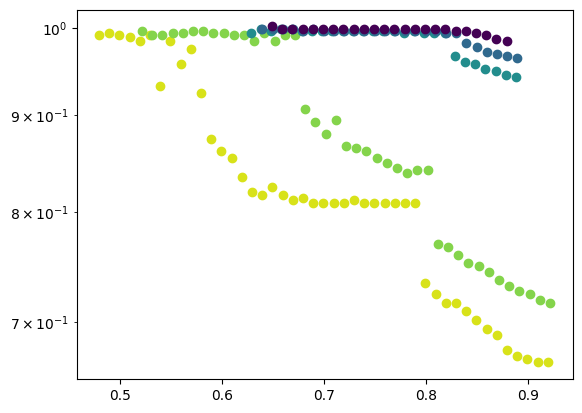

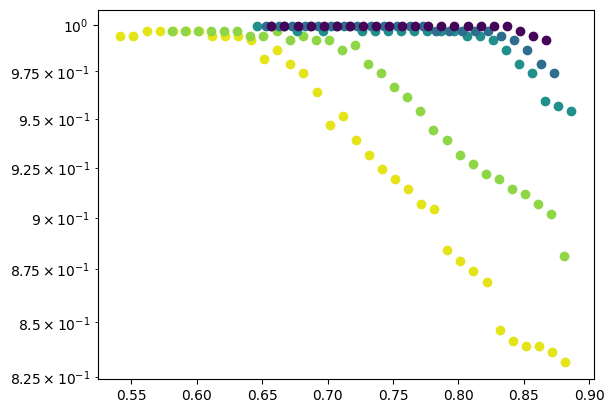

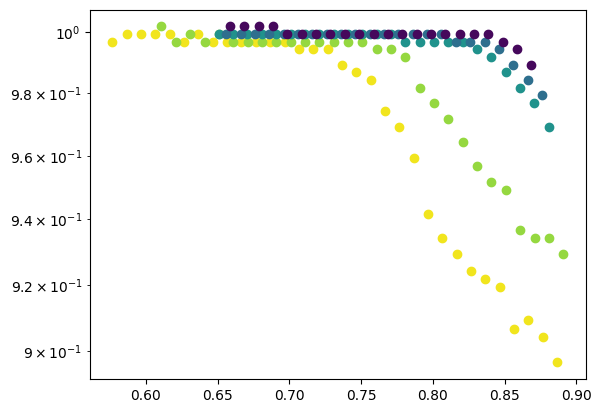

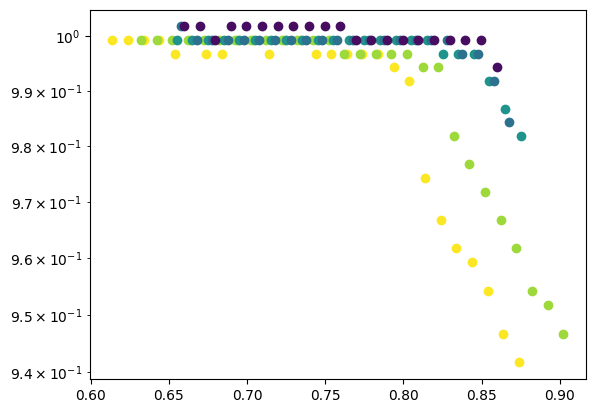

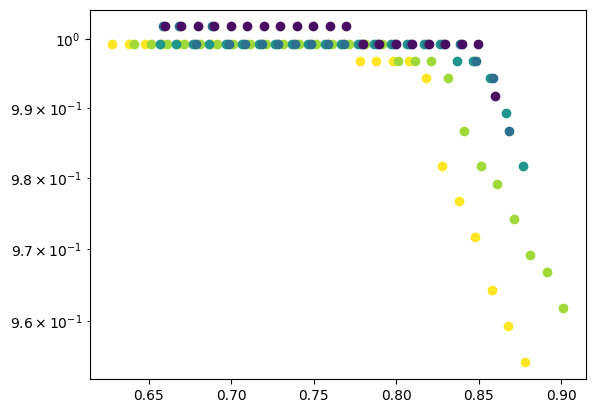

In [235]:
mu_norm = LogNorm(vmin=cold_data.mu.min(), vmax=cold_data.mu.max())
cmap = plt.cm.viridis

for nv in np.sort(hot_data.nv.unique()):
    for mu in np.sort(hot_data.mu.unique())[::-1]:
        mask = (hot_data.nv == nv) & (hot_data.mu == mu)
        r0, g0, w0 = [], [], []
        for i in range(sum(mask)):
            g = hot_data[mask].g_small.iloc[i]
            r = hot_data[mask].r.iloc[i]

            _r0, _g0, _w0, _, _ = get_peak_stats(g, r, 15)
            r0.append(_r0)
            g0.append(_g0)
            w0.append(_w0)

        plt.scatter(hot_data.phi[mask], r0, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.show()

